# Performance

## Avoiding slow code

With pandas, you'll get the most bang for your buck by *avoiding antipatterns*.
There are additional options like using Numba or Cython if you *really* need to optimize a piece of code, but that's more work typically.

This notebook will walk through several common miskates, and show more performant ways of achieving the same thing.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
plt.style.use('default')

In [2]:
%matplotlib inline

## Mistake 1: Using pandas

- At least not for things it's not meant for.
- Pandas is very fast at joins, reindex, factorization
- Not as great at, say, matrix multiplications or problems that aren't vectorizable

## Mistake 2: Using object dtype

Avoid it if possible

Jake VanderPlas has a [great article](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) on why Python is slow for many of the things we care about as analysts / scientists.
One reason is the overhead that comes from using python objects for integers, floats, etc. relative to the native versions.

As a small demonstration, we'll take two series, one with python integers, and one with NumPy's `int64`.

In [3]:
# Two series of range(10000), different dtypes
s1 = pd.Series(range(10000), dtype=object)
s2 = pd.Series(range(10000), dtype=np.int64)

In [4]:
%timeit s1.sum()

The slowest run took 6.75 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 894 µs per loop


In [5]:
%timeit s2.sum()

The slowest run took 6.72 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 109 µs per loop


NumPy can process the specialized `int64` dtype array faster than the python object version, even though they're equal.

Typically you would never expecitly pass in `dtype=object` there, but occasionally object dtypes slip into pandas

1. Strings

    This is usually unavoidable. Pandas 2 will have a specialized string
    type, but for now you're stuck with python objects. If you have few
    *distinct* values (relative to the number of rows), you could use a
    `Categorical`
<br><br>
2. Dates, Times

    Pandas has implemented a specialized verion of `datetime.datime`,
    and `datetime.timedelta`, but not `datetime.date` or `datetime.time`.
    Depending on your application, you might be able to treat dates as `datetimes`s, at midnight.
<br><br>
3. Decimal types

    Pandas uses floating-point arrays; there isn't a native arbitrary-precision Decimal type.
<br><br>
4. Reading messy Excel Files

    `read_excel` will preserve the dtype of each cell in the spreadsheet. If you
    have a single column with an int, a float, and a datetime, pandas will have to store all of those as `objects`. This dataset probably isn't tidy though.
<br><br>

5. Messy CSVs where pandas' usual inference fails
<br><br>
6. Integer NA

    Unfortunately, pandas doesn't have real nullable types. To represent
    missingness, pandas uses `NaN` (not a number) which is a special floating point value. If you *have* to represent nullable integers, you can use `object` dtype.

In [6]:
s = pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9])
s

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
5    6.0
6    7.0
7    8.0
8    9.0
dtype: float64

In [7]:
type(s[0])

numpy.float64

In [8]:
s = pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9], dtype=object)
type(s[0])

int

## Aside: Managing Dtypes

Pandas provides some tools for converting arrays to their specialized dtype.

0. IO operations (`read_csv` infers, but can use the `dtype` keyword)
1. Object -> numeric: `pd.to_numeric`
2. Object -> datetime: `pd.to_datetime`
3. Object -> timedelta: `pd.to_timedelta`
4. Object -> category: `pd.Categorical`
5. `.astype(dtype)`

They're pretty flexible what they accept.

In [9]:
numbers = ['1', '2', '3.', 'nan']
pd.to_numeric(numbers, errors='coerce')

array([  1.,   2.,   3.,  nan])

In [10]:
dates = ['2016/01/01', '2016/02/01', '2016/03/01']
pd.to_datetime(dates)

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01'], dtype='datetime64[ns]', freq=None)

In [11]:
# to_timedelta
x = pd.to_timedelta(['1H', '30s', '20blah'], errors='coerce')
x

TimedeltaIndex(['01:00:00', '00:00:30', NaT], dtype='timedelta64[ns]', freq=None)

In [12]:
pd.to_timedelta([10, 20, 30], unit="T")  # T = minutes

TimedeltaIndex(['00:10:00', '00:20:00', '00:30:00'], dtype='timedelta64[ns]', freq=None)

In [13]:
pd.Categorical(['a', 'a', 'c', 'b'], categories=['a', 'b', 'c'],
               ordered=True)

[a, a, c, b]
Categories (3, object): [a < b < c]

## Aside: Categoricals

Pandas has a custom datatype, `Categorical`, for representing data that can come from a specified, generally fixed set of values.

- `categories`: set of valid values
- `ordered`: whether that set of values has an ordering

In [14]:
c = pd.Categorical(['a', 'b', 'c', 'a'], categories=['a', 'b', 'c', 'd'])
c

[a, b, c, a]
Categories (4, object): [a, b, c, d]

Trying to insert a value that is outside the set of categories will cause an exception.

In [15]:
c[0] = 'f'

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

## Categoricals: Space Efficient

Internally, this is a dictionary encoding. The set of categories are stored *once*. The values `['a', 'b', 'c', 'a']` are stored as an array of integers, called `codes`.

In [ ]:
c.categories

In [ ]:
c.codes

Since an integer generally takes less memory to store than a string, these are an efficient way of representing data that has many repetitions. Categoricals can be stored in a DataFrame, Series, or index

In [26]:
pd.Series(c)

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): [a, b, c, d]

Pandas can take shortcuts when you use the proper dtypes.
For example, the algorithms for `value_counts` and `groupby` are simplier, and thus faster, for Categoricals than for strings (object).
We can time that:

In [27]:
N = 10000
df = pd.DataFrame({"A": np.random.randn(N),
                   "B": np.random.choice(list('abcdefg'), N)})
df['C'] = df["B"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
A    10000 non-null float64
B    10000 non-null object
C    10000 non-null category
dtypes: category(1), float64(1), object(1)
memory usage: 166.1+ KB


In [28]:
# object dtype
%timeit df.B.value_counts()

1000 loops, best of 3: 1.09 ms per loop


In [29]:
# categorical dtype
%timeit df.C.value_counts()

1000 loops, best of 3: 777 µs per loop


In [30]:
# object dtype
%timeit df.groupby("B").A.mean()

1000 loops, best of 3: 936 µs per loop


In [31]:
# categorical dtype
%timeit df.groupby("C").A.mean()

1000 loops, best of 3: 618 µs per loop


## Mistake 3: Initialization

When your collecting many different sources (say a bunch of separate CSVs) into
a single DataFrame, you have two paths to the same goal:

1. Make a single empty DataFrame, append to that
2. Make a list of many DataFrames, concat at end

Typically, in python we'd choose the first one if we were, for example, collecting things into a `list`. `list.append` is very fast. However `DataFrame.append` is *not* fast.

In [32]:
import time

size_per = 1000
N = 100
cols = list('abcd')

def timed(n=30):
    '''
    Just benchmarking
    '''
    def deco(func):
        def wrapper(*args, **kwargs):
            timings = []
            for i in range(n):
                t0 = time.time()
                func(*args, **kwargs)
                t1 = time.time()
                timings.append(t1 - t0)
            return timings
        return wrapper
    return deco

@timed(60)
def append_df():
    '''
    The pythonic (slow) way
    '''
    df = pd.DataFrame(columns=cols)
    for _ in range(N):
        df = df.append(pd.DataFrame(np.random.randn(size_per, 4),
                                    columns=cols),
                       ignore_index=True)
    return df

@timed(60)
def concat_df():
    '''
    The pandorabe (fast) way
    '''
    dfs = [pd.DataFrame(np.random.randn(size_per, 4), columns=cols)
           for _ in range(N)]
    return pd.concat(dfs, ignore_index=True)

In [33]:
t_append = append_df()
t_concat = concat_df()

timings = (pd.DataFrame({"Append": t_append, "Concat": t_concat})
             .stack()
             .reset_index()
             .rename(columns={0: 'Time (s)',
                              'level_1': 'Method'}))
timings.head()


,level_0,Method,Time (s)
0,0,Append,0.317671
1,0,Concat,0.045183
2,1,Append,0.282379
3,1,Concat,0.041363
4,2,Append,0.268410


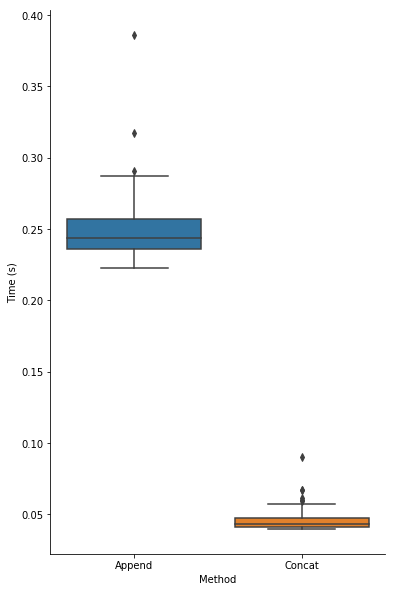

In [34]:
plt.figure(figsize=(6, 10))
sns.boxplot(x='Method', y='Time (s)', data=timings)
sns.despine()
plt.show()

## Mistake 4: Doing too much work

This is more general purpose advice, rather than something you can just grep your code for.
But look for places where you're doing a bunch of work, and then throwing some of it away.

In [5]:
# read in dep_delay column from flights
df = pd.read_csv("data/ny-flights.csv.gz", usecols=['dep_delay'])
delays = df['dep_delay']
delays.head()

0    14.0
1    -3.0
2     2.0
3    -8.0
4     2.0
Name: dep_delay, dtype: float64

That `read_csv` call unintentionally demonstrates my point. We're only going to use `dep_delay` for this example, so we pass the `usecols` parameter. This means we don't have to do any parsing or type inference on the rest of the columns, since we aren't going to use them.

For the real example though, suppose we wanted to find the 5 longest delays. One option is to sort the entire Series and then take the head

In [6]:
%timeit delays.sort_values(ascending=False).head(5)

1000 loops, best of 3: 1.86 ms per loop


A better option is to use the `nlargest` method on `Series`, and then sort just those 5 elements.

In [7]:
%timeit delays.nlargest(5).sort_values(ascending=False)

1000 loops, best of 3: 1.53 ms per loop


In can be hard to remember all the methods or algorithms available to you though.
I think this one just comes down to experience.

For another example, let's suppose we wanted to find the nearest neighbor for a bunch of points.
A naïve implementation would find the ~$N^2$ pairwise distances, and then go through finding the nearest neighbor for each.
This becomes untenable for large $N$.
Fortunately, we can be more efficient using [KDTrees](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) instead of finding all pairwise distances.
For very large $N$, various [probabilistic algorithms](https://github.com/ekzhu/datasketch) are available, but we won't talk about those today.

<div class="alert alert-success" data-title="Nearest Neighbor">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

<p>Find the nearest neighbor for all the airports with at least 500 departures.</p>

The naïve way to do this is to compute a pairwise distance matrix of all 500 airports, and then lookup the closest neighbor for each airport.

Let's avoid that unnescessary computation by using a `KDTree`.

In [ ]:
# Step 1: read in `data/flights_coord.csv`. Call the DataFrame coord
coord = ...

In [39]:
%load solutions/performance_kd.py

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_STATE_CODE,LATITUDE,LONGITUDE
0,10001,01A,"Afognak Lake, AK",AK,58.109444,-152.906667
1,10003,03A,"Granite Mountain, AK",AK,65.548056,-161.071667
2,10004,04A,"Lik, AK",AK,68.083333,-163.166667
3,10005,05A,"Little Squaw, AK",AK,67.570000,-148.183889
4,10006,06A,"Kizhuyak, AK",AK,57.745278,-152.882778


I don't know why, but apparently `AIRPORT_ID` isn't unique:

In [40]:
coord.AIRPORT.is_unique

False

You can use `.groupby().first()` to arbitrarily select the first one per airport:

In [41]:
locs = coord.groupby('AIRPORT')[['LONGITUDE', 'LATITUDE']].first()
locs.head()

,LONGITUDE,LATITUDE
AIRPORT,,
01A,-152.906667,58.109444
03A,-161.071667,65.548056
04A,-163.166667,68.083333
05A,-148.183889,67.570000
06A,-152.882778,57.745278


We'll also make a mapping between the airport IDs and names for later.

In [42]:
names = coord.groupby('AIRPORT_ID').AIRPORT.first().dropna()
names.head()

AIRPORT_ID
10001    01A
10003    03A
10004    04A
10005    05A
10006    06A
Name: AIRPORT, dtype: object

Step 3: Use [`sklearn.neighbors.KDTree`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) to find the nearest neighbors.
It's OK if you haven't used scikit-learn before; I've provided stubs of a solution below.
I'd recommend making additional cell to check the intermediate values as you solve each step.

And if you get stuck, the solution is provided afterwards.
Feel free to read through it and the KDTree docs.

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(...)  # see the docs (linked above) for KDTree

# Now use `tree.query` to find the distances and
# nearest neighbor. Make sure to pass a NumPy array to `.query`
# and not a DataFrame; otherwise scikit-learn gets confused.
# `locs.values` returns a NumPy array.

# How many neighbors (k=...) do we need? Keep in mind that
# we're searching on the same data as we built the tree on,
# so what's the "closest" point for each observation?
distances, indexes = tree.query(locs.values, k=...)

# slice the NumPy arrays to just what we need
# The array is shaped [n_observations, k] where `k` is
# what you passed to query. Column 0 is the closest,
# Column 1 is the second closest, etc...

indexes = indexes[:, 1]
distances = distances[:, 1]

# the result of KDTree.query is a list of index
# *positions*, we'll use id_map to go from 
# positions back to airport names
id_map = dict(enumerate(locs.index))

neighbors = pd.Series(indexes, index=locs.index).map(id_map)
neighbors.head()

In [48]:
%load solutions/performance_02.py


AIRPORT
01A    A75
03A    GMT
04A    UXA
05A    AK4
06A    ORI
dtype: object

## Mistake 5: Using `.apply` (with axis=1) (Avoid Iteration)

I see this one a lot. I don't like absolutes, but you should never use `.apply(..., axis=1)` (probably).
The root problem is using for loops instead of a vectorized solution.
That is, something like:

In [12]:
a = range(10)
b = range(10)
c = [a_ + b_ for a_, b_ in zip(a, b)]
c

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

Instead of the vectorized version:

In [13]:
a = np.arange(10)
b = np.arange(10)
c = a + b
c

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

http://www.labri.fr/perso/nrougier/from-python-to-numpy/ is a great resource for learning about vectorized methods.

As a demonstration, let's dip into survival analysis.
This is (roughly) the study of how much longer something will last (survive) given their current history.
For example, how much longer will someone continue to be a customer, given their past purchases?

In [14]:
from lifetimes.datasets import load_cdnow
from lifetimes import BetaGeoFitter

data = load_cdnow(index_col=[0])

data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


These are all customer-level statistics:

- frequency: number of repeat purchases
- T: "age" of the customer (units since first purchase)
- recency: age at time of last purchase

The `lifetimes.BetaGeoFitter` model has a scikit-learn-like API to estimate several parameters and has several utility methods.

In [15]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T']);

In [16]:
plt.style.use('default')

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix
plt.figure(figsize=(12, 10))
plot_probability_alive_matrix(bgf, cmap='viridis');

[Apparently](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf), we can calculate the expected number of purchases over the next $t$ periods with

\begin{align*}
    E\left(X(t) \vert \lambda, p\right) &= \lambda t \cdot P(\tau > t) + \int_0^t \lambda \tau g(\tau \vert \lambda, p)  \tau \\
    &= \frac{1}{p} - \frac{1}{p} e^{-\lambda pt}
\end{align*}

With some fancy math and substitutions, the following calculation does that.

In [56]:
from scipy import special

r, α, a, b = bgf._unload_params('r', 'alpha', 'a', 'b')
print(r, α, a, b)

def conditional_n_purchases(t, frequency, recency, T):
    x = frequency

    hyp_term = special.hyp2f1(r + x, b + x, a + b + x - 1, t / (α + T + t))
    first_term = (a + b + x - 1) / (a - 1)
    second_term = (1 - hyp_term * ((α + T) / (α + t + T)) ** (r + x))
    numerator = first_term * second_term

    denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((α + T) / (α + recency)) ** (r + x)

    return numerator / denominator

0.242591618324 4.41346949264 0.792887908651 2.42573840216


In [57]:
conditional_n_purchases(t=5, frequency=2, recency=30.43, T=38.86)

0.18315735049765852

Originally, `lifetimes`' documentation had code similar to the following:

In [58]:
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

ID
1       0.183157
2       0.029758
3       0.027552
4       0.027552
5       0.027552
          ...   
2353    0.037717
2354    0.665433
2355    0.037717
2356    0.559680
2357    0.037717
dtype: float64

Notice that's doing a `.apply(..., axis=1)`. Let's time it

In [59]:
%%timeit
t = 5
# Using .apply(λ row:, axis=1)
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

10 loops, best of 3: 124 ms per loop


You almost never want to use `.apply` with axis=1. `.apply` It's probably doing way more work that you actually want, including:

- A bunch of type inference
- Some "helpful" reductions of output shape
- Is essentially a for loop internally

If you *have* to use an interative solution (instead of vectorized), use `.itertuples` which returns an iterator of `namedtuples`.

In [60]:
next(data.itertuples())

Pandas(Index=1, frequency=2, recency=30.43, T=38.859999999999999)

In [61]:
%%timeit
t = 5
pd.Series([
    conditional_n_purchases(5, row.frequency, row.recency, row.T)
    for row in data.itertuples()
])

10 loops, best of 3: 27.6 ms per loop


But, our solution is alread vectorized thanks to NumPy and SciPy:

In [62]:
%%timeit
t = 5
# Using vectorization
conditional_n_purchases(5, data['frequency'], data['recency'], data['T'])

100 loops, best of 3: 3.25 ms per loop


It's quite natural to say "I have this complicated function `f` to apply to each 
row, I'll just just use `.apply(f, axis=1)`". Avoid that temptation.

## I/O

This is a tricky subject to say too much about since so much else goes into the decision of what IO system to use

- Do you "own" the data, or are you part of a larger system? Do you even have a choice?
- Do you need compatability with other systems?
- What types of data are you storing?

That said, some general observations

- `read_csv` is fast as far as CSV parsers go, but CSVs are *lossy* and inefficient
- `to_csv` is pretty slow (unoptimized)
- `to_sql` is *very* slow; most relational databases have dedicated methods for loading large volumes of data
- `read_json` / `to_json` are both implemented in C and fast
- `read_hdf` / `to_hdf` are both *very* fast thanks to `libhdf`, but are not threadsafe for reading or writing; The `format='table'` can perfectly represent a pandas DataFrame, but are not portable;
- `feather` is very fast, portable, but young. Pandas is adding a `read_feather` / `to_feather` in 0.20
- `parquet` support is coming along nicely in [fastparquet](http://fastparquet.readthedocs.io) and [pyarrow](https://github.com/apache/arrow/tree/master/python)